# Actief
This is the first label of our dataset we'll try to predict.
## Details
> Een actieve of passieve constructie wijst op de vorm die  het  werkwoord  aanneemt  in  de  zin.  Er  zouden eerder   actieve   constructies   worden   gebruikt   in koppen, dan passieve.Ook   verstaan   we   in   deze   studie   onder   actieve constructies koppen die directer overkomen dan hun concurrentie, die misschien wat meer omslachtig is.Bij  een  directe  kop  staat  het  hoofdnieuws  van  het artikel vooraan, een indirectere kop geeft eerst nog watalgemene of onbeduidende informatie.
## Example
> Actief: Weg met perfectie: H&M werktde kleine details van bikinimodellen niet langer weg
> Passief:  Weg  met  perfectie:  striemen,  beharing en littekens     van badpakmodellen H&M (worden) niet langer gefotoshopt
> Directer: Proximus werktaan  eigen  Belgische Netflix
> Indirecter: Proximus denktaan  eigen  Belgische Netflix
## Data

In [1]:
from util import get_cls_train_test
train_x, train_y, test_x, test_y = get_cls_train_test("Actief")
train_y.value_counts()

Actief
1         1388
0          304
dtype: int64

## Approach 1: Past paricle
A passive construction will often contain a past particle, so it might be useful to train a model to search for those. However, this won't be an ideal scenario, since more indirect forms (like the one given above using "to think") will be ignored with this.
In the English language, we have following markers for a passive construction: be, -ed and by ([src](https://www.academypublication.com/issues/past/jltr/vol01/06/32.pdf), Classification and SLA Studies of Passive Voice, Yuanying Wang). This translates in dutch to forms of "worden", "ge-" and "door".

In [2]:
def is_passive(headline):
    # TODO: Maybe I can check this with spacy? Since this manual construction is probbly overfitting

    # Check if any word in headline start with "ge"
    for word in headline.split():
        if word.startswith("ge") or word.startswith("Ge"):
            return True
        if word == "door" or word == "Door":
            return True
        if "word" in word or word in ["zijn", "is", "ben", "bent"]:  # Check for any form of the verb "worden"
            return True
    return False


def is_active(headline):
    return not is_passive(headline)


print(is_passive("Verdachte gevlucht na overval"))

True


f-score: 0.5551020408163265
Confusion matrix: (TP: 34, FP: 50, FN: 277, TN: 204)
Accuracy=34.36% (238/565)


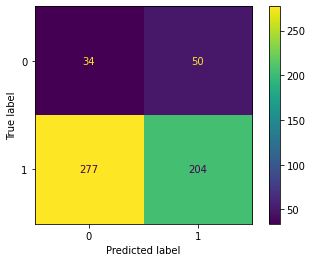

In [3]:
from util import print_evalution
import numpy as np
predictions = np.vectorize(is_passive)(test_x)
print_evalution(test_y, predictions)